In [1]:
!pip install tensorflow-addons

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense,Conv2D,MaxPool2D,Dropout,GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision, Recall
import tensorflow as tf
import cv2

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
epochs = 30

In [4]:
files = glob(r'Datasets\Rock Classification Dataset\*\*\*.*')
len(files)

2083

In [5]:
files[:5]

['Datasets\\Rock Classification Dataset\\Igneous\\Basalt\\1.jpg',
 'Datasets\\Rock Classification Dataset\\Igneous\\Basalt\\10.jpg',
 'Datasets\\Rock Classification Dataset\\Igneous\\Basalt\\11.jpg',
 'Datasets\\Rock Classification Dataset\\Igneous\\Basalt\\12.jpg',
 'Datasets\\Rock Classification Dataset\\Igneous\\Basalt\\13.jpg']

In [6]:
label = [file.split('\\')[3] for file in files]

In [7]:
set(label)

{'Basalt', 'Coal', 'Granite', 'Limestone', 'Marble', 'Quartzite', 'Sandstone'}

In [8]:
df = pd.DataFrame({'file_path' : files,
                   'label': label})
df.head()

,file_path,label
0,Datasets\Rock Classification Dataset\Igneous\B...,Basalt
1,Datasets\Rock Classification Dataset\Igneous\B...,Basalt
2,Datasets\Rock Classification Dataset\Igneous\B...,Basalt
3,Datasets\Rock Classification Dataset\Igneous\B...,Basalt
4,Datasets\Rock Classification Dataset\Igneous\B...,Basalt


In [9]:
df['file_path'].str.split('.').apply(lambda x : x[-1]).value_counts()

jpg     2004
jpeg      28
JPEG      20
png       17
jfif       7
webp       7
Name: file_path, dtype: int64

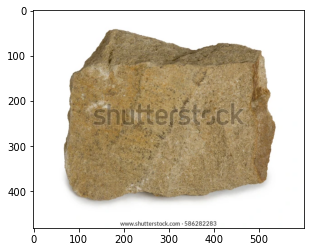

In [10]:
plt.imshow(plt.imread(r'Datasets/Rock classification Dataset/Sedimentary/Sandstone/320.webp'))# Dataset\Sedimentary\Limestone\291.jfif     

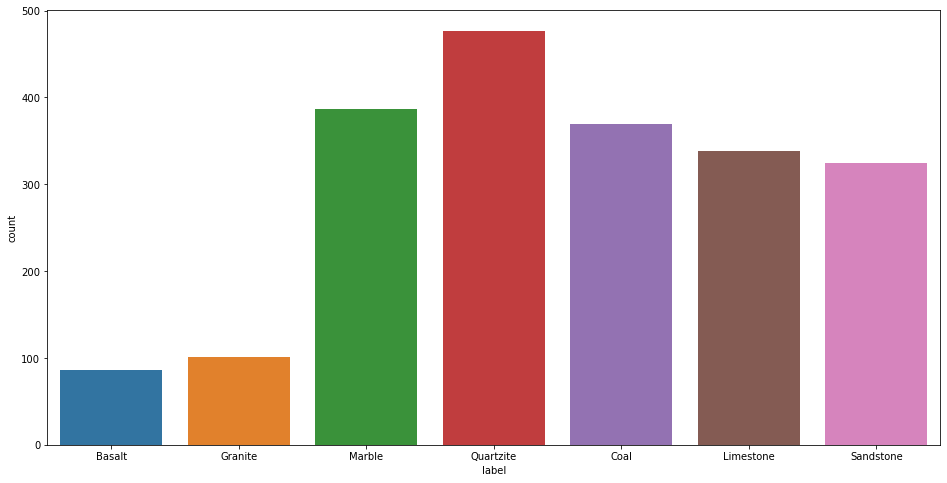

In [11]:
plt.figure(figsize=(16,8))
sns.countplot(x =df['label'])
plt.show()

In [12]:
df_train , df_val =train_test_split(
    df, test_size=0.2,
    random_state=1, stratify=df['label']
)

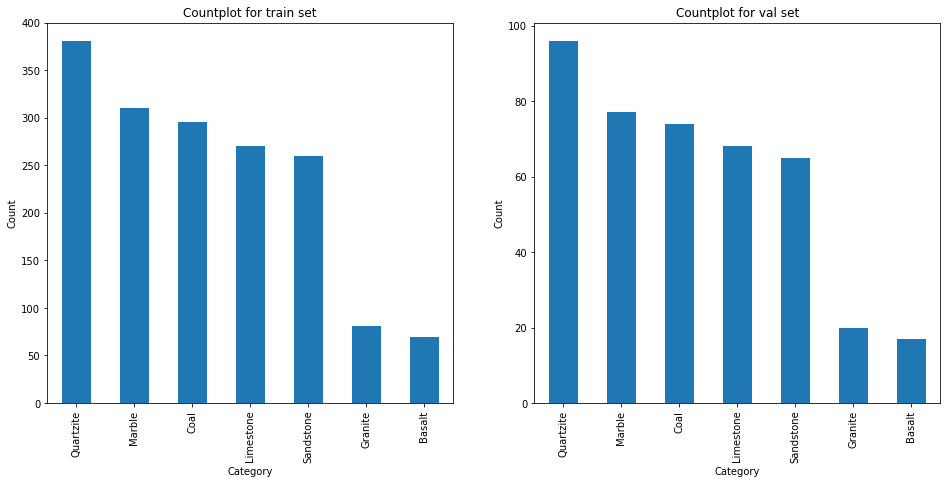

In [13]:
fig, ax = plt.subplots(figsize=(16,7), nrows=1,ncols=2)
df_train['label'].value_counts().plot(ax=ax[0],kind='bar', xlabel='Category', ylabel='Count', title='Countplot for train set')
df_val['label'].value_counts().plot(ax=ax[1],kind='bar', xlabel='Category', ylabel='Count', title='Countplot for val set')
plt.show()

In [14]:
train_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
#     preprocessing_function = efn.preprocess_input
)

# Only rescaling the val set
val_gen = ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
#     preprocessing_function = efn.preprocess_input
)

In [15]:
train_set = train_gen.flow_from_dataframe(
    df_train, 
    x_col='file_path',
    y_col='label',
    target_size=(IMAGE_SIZE,IMAGE_SIZE), 
    class_mode='categorical', 
    shuffle=True, 
    batch_size=BATCH_SIZE)
val_set = val_gen.flow_from_dataframe(
    df_val , 
    x_col='file_path',
    y_col='label',
    target_size=(IMAGE_SIZE,IMAGE_SIZE), 
    class_mode='categorical', 
    shuffle=True, 
    batch_size=BATCH_SIZE)

Found 1653 validated image filenames belonging to 7 classes.
Found 416 validated image filenames belonging to 7 classes.


C:\Users\mmmmmm\anaconda3\envs\Deeplearning\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 13 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '
C:\Users\mmmmmm\anaconda3\envs\Deeplearning\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [16]:
class_dict = {v:k for k,v in train_set.class_indices.items()}
class_dict
NUM_CLASS = len(class_dict)

In [17]:
def see_examples(datagen, figsize=(16,16),nrows=4, ncols=4):
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    batch_idx = np.random.randint(low=0, high=len(datagen), size=(nrows,ncols))
    for i in range(nrows):
        for j in range(ncols):
            imgs, labels = datagen[batch_idx[i,j]]
            sample_idx = np.random.randint(low=0, high=len(imgs))
            img = imgs[sample_idx]
            label = labels[sample_idx]
            label = class_dict[np.argmax(label)]
            ax[i,j].axis('off')
            ax[i,j].imshow(img)
            ax[i,j].set_title(label)
    plt.show()

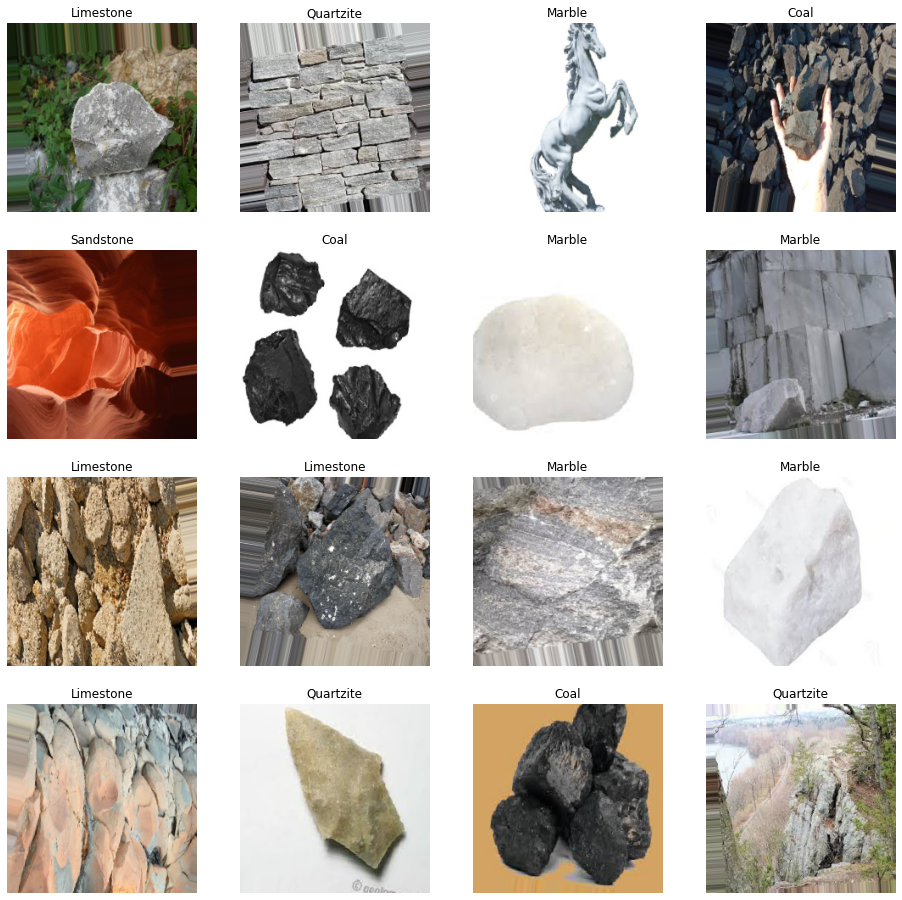

In [18]:
see_examples(train_set)

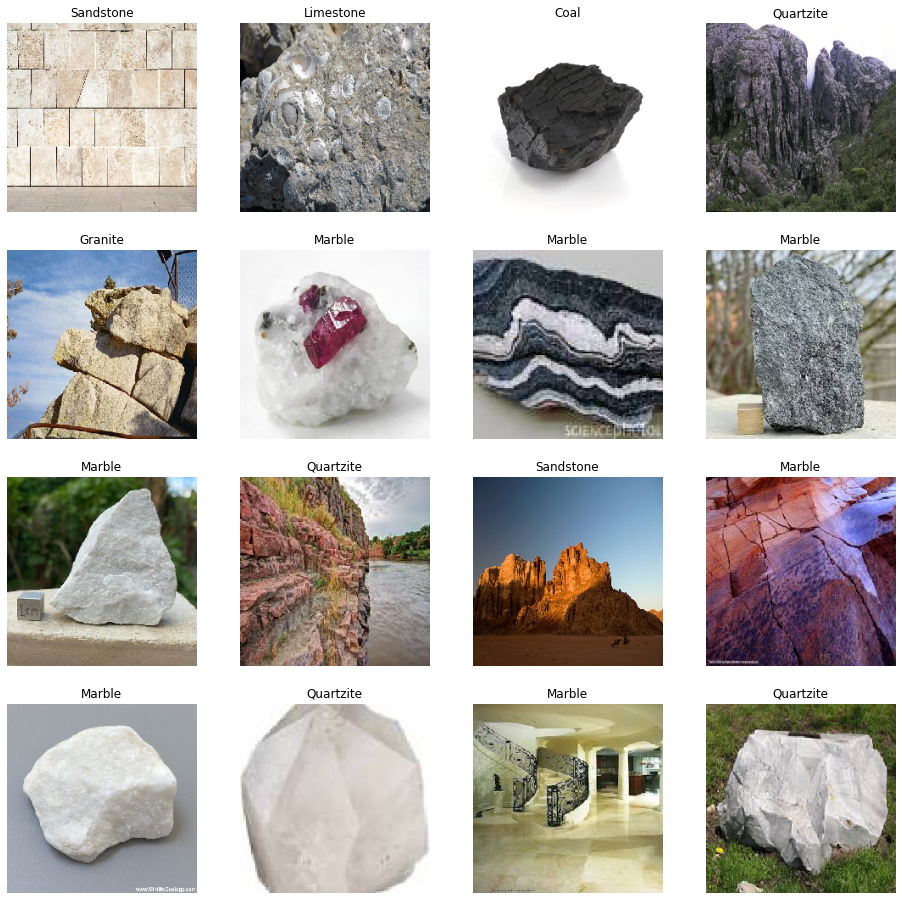

In [19]:
see_examples(val_set)

In [20]:
conv_base = efn.EfficientNetB0(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))
conv_base.trainable=False

In [21]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block6a_expand_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False 

# conv_base.trainable = True

# set_trainable = False
# for layer in conv_base.layers:
#     if layer.name == 'block5_conv1':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False 


In [22]:
model = Sequential([
    conv_base,
    GlobalAveragePooling2D(),
    
    Dense(units=512,activation='relu'),
    Dropout(0.2),
    Dense(units=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=NUM_CLASS, activation='softmax')
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [24]:
callbacks = [
    EarlyStopping(min_delta=1e-5, patience=5),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.001)
]

metrics = [
    CategoricalAccuracy(), 
    F1Score(num_classes=NUM_CLASS), 
    Precision(), 
    Recall(), 
#     AUC()
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [25]:
history = model.fit(train_set,epochs=epochs, batch_size=BATCH_SIZE,
                  validation_data=val_set,callbacks= callbacks
                             )

Epoch 1/30
26/26 [==============================] - 153s 6s/step - loss: 1.4642 - categorical_accuracy: 0.4670 - f1_score: 0.3570 - precision: 0.7241 - recall: 0.2160 - val_loss: 1.6964 - val_categorical_accuracy: 0.5048 - val_f1_score: 0.3638 - val_precision: 0.6250 - val_recall: 0.4087 - lr: 0.0010
Epoch 2/30
26/26 [==============================] - 147s 6s/step - loss: 0.8703 - categorical_accuracy: 0.6909 - f1_score: 0.5749 - precision: 0.7914 - recall: 0.5759 - val_loss: 1.6625 - val_categorical_accuracy: 0.5529 - val_f1_score: 0.4278 - val_precision: 0.5811 - val_recall: 0.5168 - lr: 0.0010
Epoch 3/30
26/26 [==============================] - 151s 6s/step - loss: 0.6211 - categorical_accuracy: 0.7774 - f1_score: 0.7214 - precision: 0.8416 - recall: 0.7042 - val_loss: 1.4475 - val_categorical_accuracy: 0.6538 - val_f1_score: 0.5710 - val_precision: 0.6852 - val_recall: 0.6226 - lr: 0.0010
Epoch 4/30
26/26 [==============================] - 149s 6s/step - loss: 0.4975 - categorical_

In [26]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,categorical_accuracy,f1_score,precision,recall,val_loss,val_categorical_accuracy,val_f1_score,val_precision,val_recall,lr
0,1.464166,0.467030,"[0.038095236, 0.50676984, 0.022727272, 0.53285...",0.724138,0.215971,1.696398,0.504808,"[0.0, 0.25287357, 0.0, 0.52586204, 0.5222222, ...",0.625000,0.408654,0.001
1,0.870346,0.690865,"[0.30612242, 0.82679737, 0.10309278, 0.7099099...",0.791355,0.575923,1.662451,0.552885,"[0.0, 0.7258064, 0.095238104, 0.5876777, 0.562...",0.581081,0.516827,0.001
2,0.621124,0.777374,"[0.5, 0.8721312, 0.5413534, 0.8038835, 0.71163...",0.841649,0.704174,1.447450,0.653846,"[0.21052632, 0.6666666, 0.35714287, 0.67052025...",0.685185,0.622596,0.001
3,0.497516,0.829401,"[0.64179105, 0.93559325, 0.70198673, 0.8517111...",0.869418,0.777374,1.213188,0.682692,"[0.46153846, 0.79365075, 0.5217392, 0.74025977...",0.711957,0.629808,0.001
4,0.412105,0.857229,"[0.6890756, 0.9378151, 0.7407407, 0.86527514, ...",0.893325,0.825771,1.318625,0.656250,"[0.27450982, 0.71794873, 0.60606056, 0.7152318...",0.682051,0.639423,0.001


In [27]:
history_df['f1_score'] = history_df['f1_score'].apply(np.mean)
history_df['val_f1_score'] = history_df['val_f1_score'].apply(np.mean)

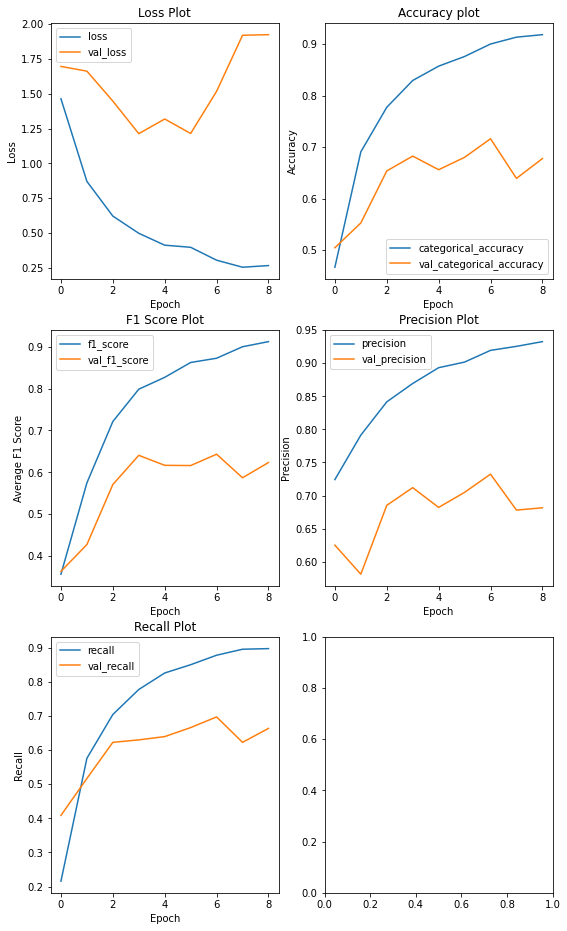

In [29]:
fig, ax = plt.subplots(figsize=(9,16), nrows=3,ncols=2)
history_df[['loss','val_loss']].plot(ax=ax[0,0], xlabel='Epoch',ylabel='Loss', title='Loss Plot')
history_df[['categorical_accuracy','val_categorical_accuracy']].plot(
    ax=ax[0,1], xlabel='Epoch',ylabel='Accuracy',title='Accuracy plot')
history_df[['f1_score','val_f1_score']].plot(ax=ax[1,0],xlabel='Epoch',ylabel='Average F1 Score',title='F1 Score Plot')
history_df[['precision','val_precision']].plot(ax=ax[1,1],xlabel='Epoch',ylabel='Precision',title='Precision Plot')
history_df[['recall','val_recall']].plot(ax=ax[2,0],xlabel='Epoch',ylabel='Recall',title='Recall Plot')
# history_df[['auc','val_auc']].plot(ax=ax[2,1],xlabel='Epoch',ylabel='AUC',title='AUC Plot')
plt.show()

In [30]:
best_model = load_model('best_model.h5')

In [31]:
val_loss,val_acc, val_f1, val_precision, val_recall = best_model.evaluate(val_set)

7/7 [==============================] - 18s 2s/step - loss: 1.2132 - categorical_accuracy: 0.6827 - f1_score: 0.6407 - precision: 0.7120 - recall: 0.6298


In [43]:
df_val['file_path'].str.split('.').apply(lambda x : x[-1])[df_val['file_path'].str.split('.').apply(lambda x : x[-1]) == 'webp']

572    webp
Name: file_path, dtype: object

In [44]:
df_val.drop(index=572,inplace=True)

In [46]:
# val_preds = best_model.predict(val_set)
# val_preds = val_preds.argmax(axis=1)

df_val['label_num'] = df_val['label'].map(val_set.class_indices)
df_val['Predicted'] = val_preds
df_val.head()

,file_path,label,label_num,Predicted
1421,Datasets\Rock Classification Dataset\Sedimenta...,Limestone,3,5
1849,Datasets\Rock Classification Dataset\Sedimenta...,Sandstone,6,6
37,Datasets\Rock Classification Dataset\Igneous\B...,Basalt,0,5
717,Datasets\Rock Classification Dataset\Metamorph...,Quartzite,5,3
569,Datasets\Rock Classification Dataset\Metamorph...,Marble,4,5


In [47]:
conf_mat = confusion_matrix(y_true=df_val['label_num'], y_pred=df_val['Predicted'])
conf_mat = pd.DataFrame(conf_mat, index=val_set.class_indices.keys(), columns=val_set.class_indices.keys())

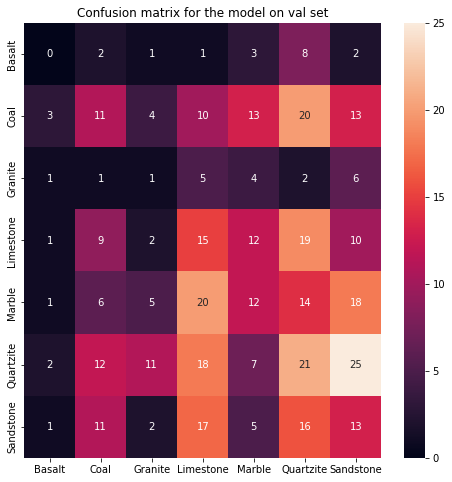

In [48]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, ax=ax , fmt='d')
ax.set_title('Confusion matrix for the model on val set')
plt.show()